# Creating local estimates of boundary of basin of attraction

## Model a dynamical system

We model the Lorenz system, which consists of the following three ODEs: 

$$x'=\sigma(y-x) \\
y'=rx-y-xz \\
z'=xy-\beta z$$

In [13]:
import numpy as np
import math
from scipy.integrate import solve_ivp

We set some parameters and do a test simulation to observe the convergence process to a stable equilibrium. The simulation code is referenced from https://github.com/scipython/scipython-maths/blob/master/lorenz/lorenz.py

In [14]:
# Lorenz parameters and initial conditions.
sigma, beta, r = 10, 2.667, 10
x0, y0, z0 = 0, 1, 1.05

# Maximum time point and total number of time points.
tmax, n = 5000, 100000

In [15]:
def lorenz(t, X, sigma, beta, r):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [16]:
# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

After numerically solving the problem, we plot the trajectory.

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [18]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

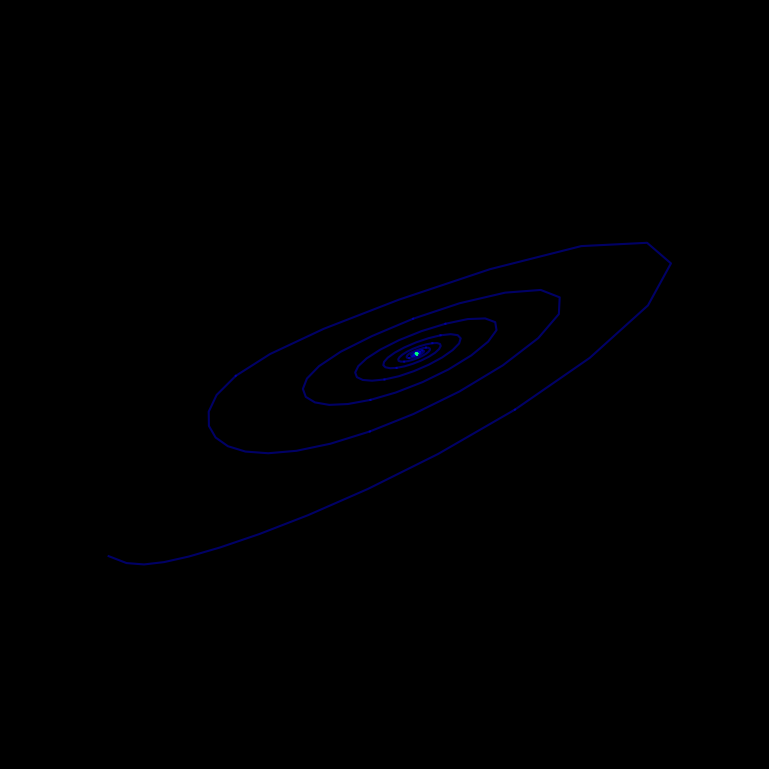

In [19]:
# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.savefig('lorenz_win.png', dpi=DPI)
plt.show()

By the setting of parameters, the system has two stable equilibriums. 

By checking the trace of the trajectory, we could observe that the flow converges to one of them.

## Simulation to collect data

We now form a dataset for training and testing with the following way: We randomly select initial conditions $(x_{0},y_{0},z_{0}) \in (-50,50)\times (-50,50) \times (-50,50)$ and compute the trajectories. We fix a stable equilibrium of interest, and label the points as 1 or -1 depending on whether the trajectory converges to that equilibrium. With the above set of parameters, we have that $(\sqrt{24}, \sqrt{24}, 9)$ is a stable equilibrium. We therefore obtain a dataset by simulating the trajectory of 500 sample points. If the trajectory is attracted, we label it as +1, otherwise -1.

In [20]:
# Check if the trajectory is attracted to the concerned Lorenz attractor
def is_attracted(x, y, z):
    return (abs(x-math.sqrt(24))<0.01) and (abs(y-math.sqrt(24))<0.01) and (abs(z-9)<0.01)

In [21]:
## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0 ,z0):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    return is_attracted(x[n-1], y[n-1], z[n-1])

In [22]:
def generate_random_points():
    x0 = np.random.uniform(-50, 50)
    y0 = np.random.uniform(-50, 50)
    z0 = np.random.uniform(-50, 50)
    return x0, y0, z0

In [23]:
import pandas as pd

# Create the dataset
df = pd.DataFrame(columns=['x0', 'y0', 'z0', 'attracted'])
for i in range(2000):
    x0, y0, z0 = generate_random_points()
    attracted_result = simulation(x0, y0, z0)
    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
    df.loc[i] = [x0, y0, z0, attracted_result]
    if i % 10 == 0:  # print progress every 10 iterations
        print(f"Progress: {i}/2000")

# Save the DataFrame to a CSV file
df.to_csv('dataset.csv', index=False)

Progress: 0/2000
Progress: 10/2000
Progress: 20/2000
Progress: 30/2000
Progress: 40/2000
Progress: 50/2000
Progress: 60/2000
Progress: 70/2000
Progress: 80/2000
Progress: 90/2000
Progress: 100/2000
Progress: 110/2000
Progress: 120/2000
Progress: 130/2000
Progress: 140/2000
Progress: 150/2000
Progress: 160/2000
Progress: 170/2000
Progress: 180/2000
Progress: 190/2000
Progress: 200/2000
Progress: 210/2000
Progress: 220/2000
Progress: 230/2000
Progress: 240/2000
Progress: 250/2000
Progress: 260/2000
Progress: 270/2000
Progress: 280/2000
Progress: 290/2000
Progress: 300/2000
Progress: 310/2000
Progress: 320/2000
Progress: 330/2000
Progress: 340/2000
Progress: 350/2000
Progress: 360/2000
Progress: 370/2000
Progress: 380/2000
Progress: 390/2000
Progress: 400/2000
Progress: 410/2000
Progress: 420/2000
Progress: 430/2000
Progress: 440/2000
Progress: 450/2000
Progress: 460/2000
Progress: 470/2000
Progress: 480/2000
Progress: 490/2000
Progress: 500/2000
Progress: 510/2000
Progress: 520/2000
Prog

## Reproduction of Shena et.al approach using deep neural network

With dataset generated, we will train a neural network to perform logistic regression by minimizing cross-entropy loss.